In [13]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [14]:
# initialising the ID

id_model = gum.InfluenceDiagram()

treatment = id_model.addDecisionNode(gum.LabelizedVariable('treatment', 'Treatment options', ['Surgery', 'Chemotherapy', 'RadioTherapy']))

general_health = id_model.addChanceNode(gum.LabelizedVariable('general_health', 'General Health of patient', ['Good', 'Medium', 'Poor']))
side_effects = id_model.addChanceNode(gum.LabelizedVariable('side_effects', 'side effects of the treatment', ['Mild', 'Moderate', 'Severe']))
treatment_duration = id_model.addChanceNode(gum.LabelizedVariable('treatment_duration', 'Treatment Duration', ['Long', 'Medium', 'Short']))

quality_of_life = id_model.addUtilityNode(gum.LabelizedVariable('quality_of_life', 'Quality of life', 1))

In [15]:
# setting the arc, ie dependencies, between nodes

id_model.addArc(general_health, treatment)
id_model.addArc(side_effects, quality_of_life)
id_model.addArc(treatment, quality_of_life)
id_model.addArc(treatment, side_effects)
id_model.addArc(treatment, treatment_duration)
id_model.addArc(treatment_duration, quality_of_life)

In [16]:
# filling conditional probability tables (cpt) (here arbitrarily, but usually using previous data)

id_model.cpt(general_health).fillWith([0.1, 0.3, 0.6])

id_model.cpt(side_effects)[{'treatment':'Surgery'}] = [0.3, 0.2, 0.5]
id_model.cpt(side_effects)[{'treatment':'Chemotherapy'}] = [0.1, 0.2, 0.7]
id_model.cpt(side_effects)[{'treatment':'RadioTherapy'}] = [0.6, 0.3, 0.1]

id_model.cpt(treatment_duration)[{'treatment':'Surgery'}] = [0.1, 0.2, 0.7]
id_model.cpt(treatment_duration)[{'treatment':'Chemotherapy'}] = [0.7, 0.2, 0.1]
id_model.cpt(treatment_duration)[{'treatment':'RadioTherapy'}] = [0.3, 0.2, 0.5]

# printing out one of the cpts

node_name = 'side_effects'
node = id_model.cpt(node_name)
print(node)


      ||  side_effects               |
treatm||Mild     |Moderate |Severe   |
------||---------|---------|---------|
Surger|| 0.3000  | 0.2000  | 0.5000  |
Chemot|| 0.1000  | 0.2000  | 0.7000  |
RadioT|| 0.6000  | 0.3000  | 0.1000  |



In [17]:
# utilities

id_model.utility(quality_of_life)[{'treatment':'Surgery', 'side_effects':'Mild', 'treatment_duration':'Long'}] = 20
id_model.utility(quality_of_life)[{'treatment':'Surgery', 'side_effects':'Mild', 'treatment_duration':'Medium'}] = 30
id_model.utility(quality_of_life)[{'treatment':'Surgery', 'side_effects':'Mild', 'treatment_duration':'Short'}] = 40

# ... and so on, for all 27 arrangements of variable values
# or, loop thru them and assign each chance node a weighted value to add to the utility

for tre_val in ['Surgery', 'Chemotherapy', 'RadioTherapy']:
    for side_val in ['Mild', 'Moderate', 'Severe']:
        for dura_val in ['Long', 'Medium', 'Short']:
            id_model.utility(quality_of_life)[{'treatment':tre_val, 'side_effects':side_val, 'treatment_duration':dura_val}] = (
                0.2 * (10 if tre_val=='Surgery' else (20 if tre_val=='Chemotherapy' else 5)) + 
                0.5 * (50 if side_val=='Mild' else (40 if side_val=='Moderate' else 0)) + 
                0.3 * (20 if dura_val=='Long' else (30 if dura_val=='Medium' else 60))
            )

def print_all_utilities(model):
    for node_name in model.names():
        if model.isUtilityNode(node_name):
            print(f'Utility value of {node_name}')
            print(model.utility(node_name))

print_all_utilities(id_model)

Utility value of quality_of_life

                    ||  quality|
side_e|treatm|treatm||0        |
------|------|------||---------|
Mild  |Surger|Long  || 33.0000 |
Modera|Surger|Long  || 28.0000 |
Severe|Surger|Long  || 8.0000  |
Mild  |Chemot|Long  || 35.0000 |
Modera|Chemot|Long  || 30.0000 |
Severe|Chemot|Long  || 10.0000 |
[...15 more line(s) ...]
Mild  |Chemot|Short || 47.0000 |
Modera|Chemot|Short || 42.0000 |
Severe|Chemot|Short || 22.0000 |
Mild  |RadioT|Short || 44.0000 |
Modera|RadioT|Short || 39.0000 |
Severe|RadioT|Short || 19.0000 |



In [21]:
# inference to get optimal decision

limid = gum.ShaferShenoyLIMIDInference(id_model)
limid.makeInference()

optimal_decision = limid.optimalDecision(treatment)
print(optimal_decision)


  treatment                  |
Surgery  |Chemother|RadioTher|
---------|---------|---------|
 0.0000  | 0.0000  | 1.0000  |



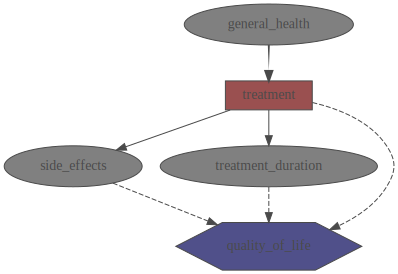

In [18]:
gnb.showInfluenceDiagram(id_model)

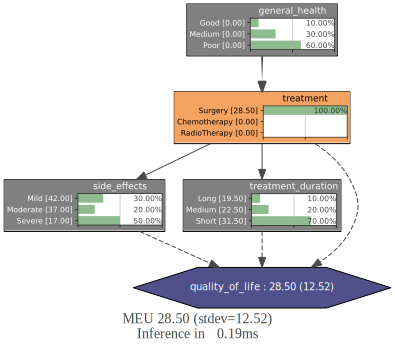

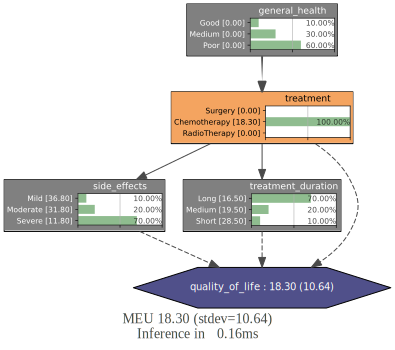

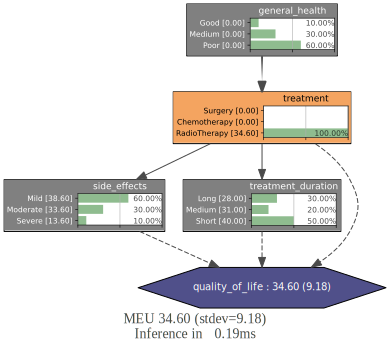

In [27]:
gnb.sideBySide(gnb.getInference(id_model, engine=limid))
gnb.showInference(id_model, evs={'treatment':'Surgery'})
gnb.showInference(id_model, evs={'treatment':'Chemotherapy'})
gnb.showInference(id_model, evs={'treatment':'RadioTherapy'})